In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [2]:
%load_ext autoreload
%autoreload 2


In [3]:

# Load the CSV file into a dataframe
# dfv00 = pd.read_csv("reps-exp-rep-code-v0.0/gnn_reps_exp_rep_code_results.csv") #initial sweep with small n_train
# dfv01 = pd.read_csv("reps-exp-rep-code-v0.1/gnn_reps_exp_rep_code_results.csv") # more n_train, larger lr sweep

#v0.2: much smaller betas, but too much statistical noise to actually see an effect. Also, half the lr's are too big.
# dfv02 = pd.read_csv("reps-exp-rep-code-v0.2/gnn_reps_exp_rep_code_results.csv") 
# df = df[(df["lr"] >= 0.01) & (df["lr"] <= 0.03)]

# sweep over betas in [1, 1.1, 1.2, 1.3, 1.4], n_train up to 16000ish, first run with n_trials > 1 (MIXED INITIAL STATES in data)
dfv03 = pd.read_csv("reps-exp-rep-code-v0.3/gnn_reps_exp_rep_code_results.csv")



In [4]:
# df = pd.concat([dfv00, dfv01])
df = dfv03

# remove all lr greater than 0.03 or less than 0.01


In [5]:
df.head()

,job_id,epoch,train_loss,train_acc,val_loss,val_acc,vs_lookup,vs_minweight,lr,batch_size,gcn_depth,gcn_min,mlp_depth,mlp_max,n_train,beta,job_id.1,total_parameters,total_time,total_epochs
0,0,120,0.071183,0.977705,0,0.913754,0,-998.086246,0.015,256,3,64,4,128,16192,1.0,0,52481,901.746960,648
1,1,220,0.376378,0.913086,0,0.910172,0,-998.089828,0.015,256,4,32,4,128,2048,1.0,1,56481,280.248094,990
2,2,250,0.120808,0.965820,0,0.915576,0,-998.084424,0.010,256,4,64,3,128,8192,1.0,2,175169,888.425534,706
3,3,350,0.384919,0.912109,0,0.898314,0,-998.101686,0.015,256,2,32,4,128,512,1.0,3,23521,141.022160,1032
4,4,230,0.290235,0.923828,0,0.900692,0,-998.099308,0.015,256,2,64,3,128,512,1.0,4,43713,212.825974,1473


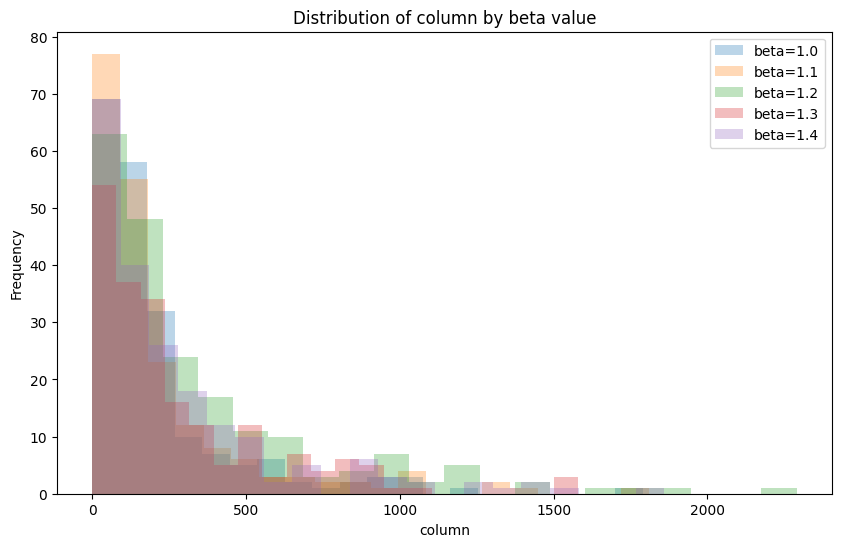

In [6]:
# Create histogram overlaying distributions for different beta values
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique beta values
unique_betas = df["beta"].unique()

# Create histogram for each beta value
for beta in unique_betas:
    subset = df[df["beta"] == beta]
    ax.hist(subset["epoch"], alpha=0.3, label=f"beta={beta}", bins=20)

ax.set_xlabel("column")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of column by beta value")
ax.legend()
plt.show()


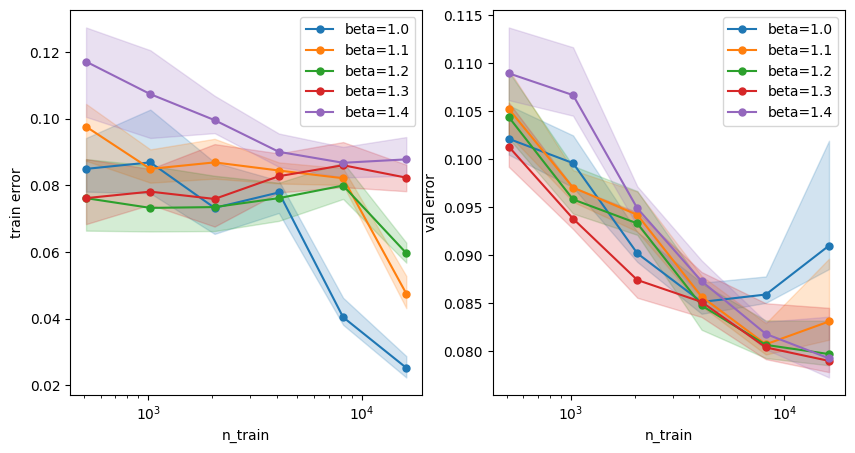

In [7]:
# NEED TO INCREASE LEARNING RATE A LOT

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
betas = list(df["beta"].unique())
# create a list of colors as long as betas
colors = [f"C{i}" for i in range(len(betas))]

labels = ["train error", "val error"]
# n_train = 4096
x_column = 'n_train'
for p, metric in enumerate(["train_acc", "val_acc"]):
    ax = axes[p]
    for i, beta in enumerate(betas):
        c = colors[i]
        lr_med = []
        lr_ub = []
        lr_lb = []
        xvals = sorted(df[x_column].unique())
        label = f"beta={beta}"
        for j, lr in enumerate(xvals):
            slice = ((df[x_column] == lr) & (df["beta"] == beta))
            median = 1 - df[slice][metric].median()
            # get IQ range of the distribution
            lb = 1 - df[slice][metric].quantile(0.25)
            ub = 1 - df[slice][metric].quantile(0.75)
            lr_med.append(median)
            lr_ub.append(ub)
            lr_lb.append(lb)
        ax.plot(xvals, lr_med, c=c, label=label, marker='o', markersize=5,)
        ax.fill_between(xvals, lr_ub, lr_lb, alpha=0.2, color=c)
        ax.set_xscale('log')
        # break
    ax.set_xlabel(x_column)
    ax.set_ylabel(f"{labels[p]}")
    ax.legend()

plt.show()


In [8]:
# load some data for manual investigation
from mldec.datasets.reps_exp_rep_code_data import make_exp_dataset_name, load_data
n = 5
T = 5
XY_sets = []
for beta in [1, 1.1, 1.2, 1.3, 1.4]:
    fname = make_exp_dataset_name(n, T, beta)
    X, y = load_data(fname)
    XY_sets.append((X, y))


In [12]:
from mldec.datasets.reps_exp_rep_code_data import sample_dataset
from collections import Counter
dataset_config = {
    "code_size": 5,
    "repetitions": 5,
    "beta": 1,
}
n_train = 16192
seed = None
randomize = True
buffer, trivial_count, observable_flips = sample_dataset(n_train, dataset_config, "cpu", seed=None, randomize=True)

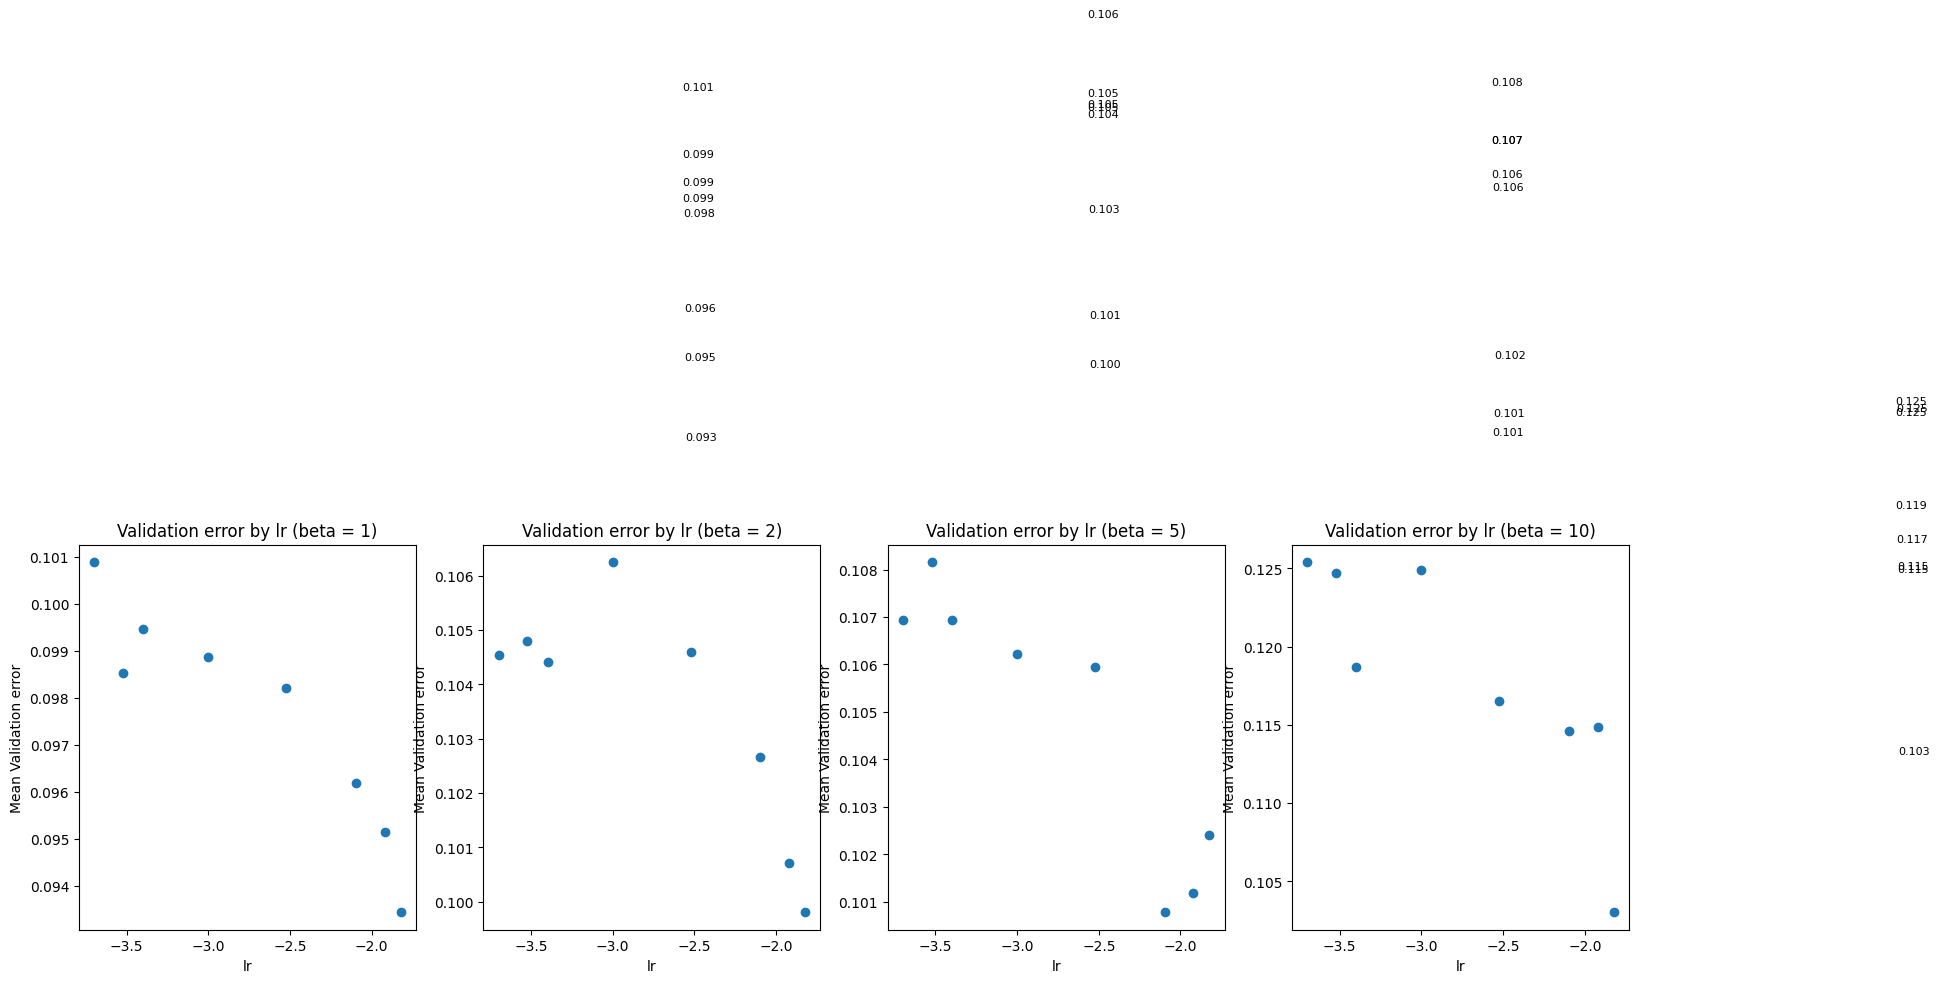

ValueError: Image size of 1655x86456 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2000x500 with 4 Axes>

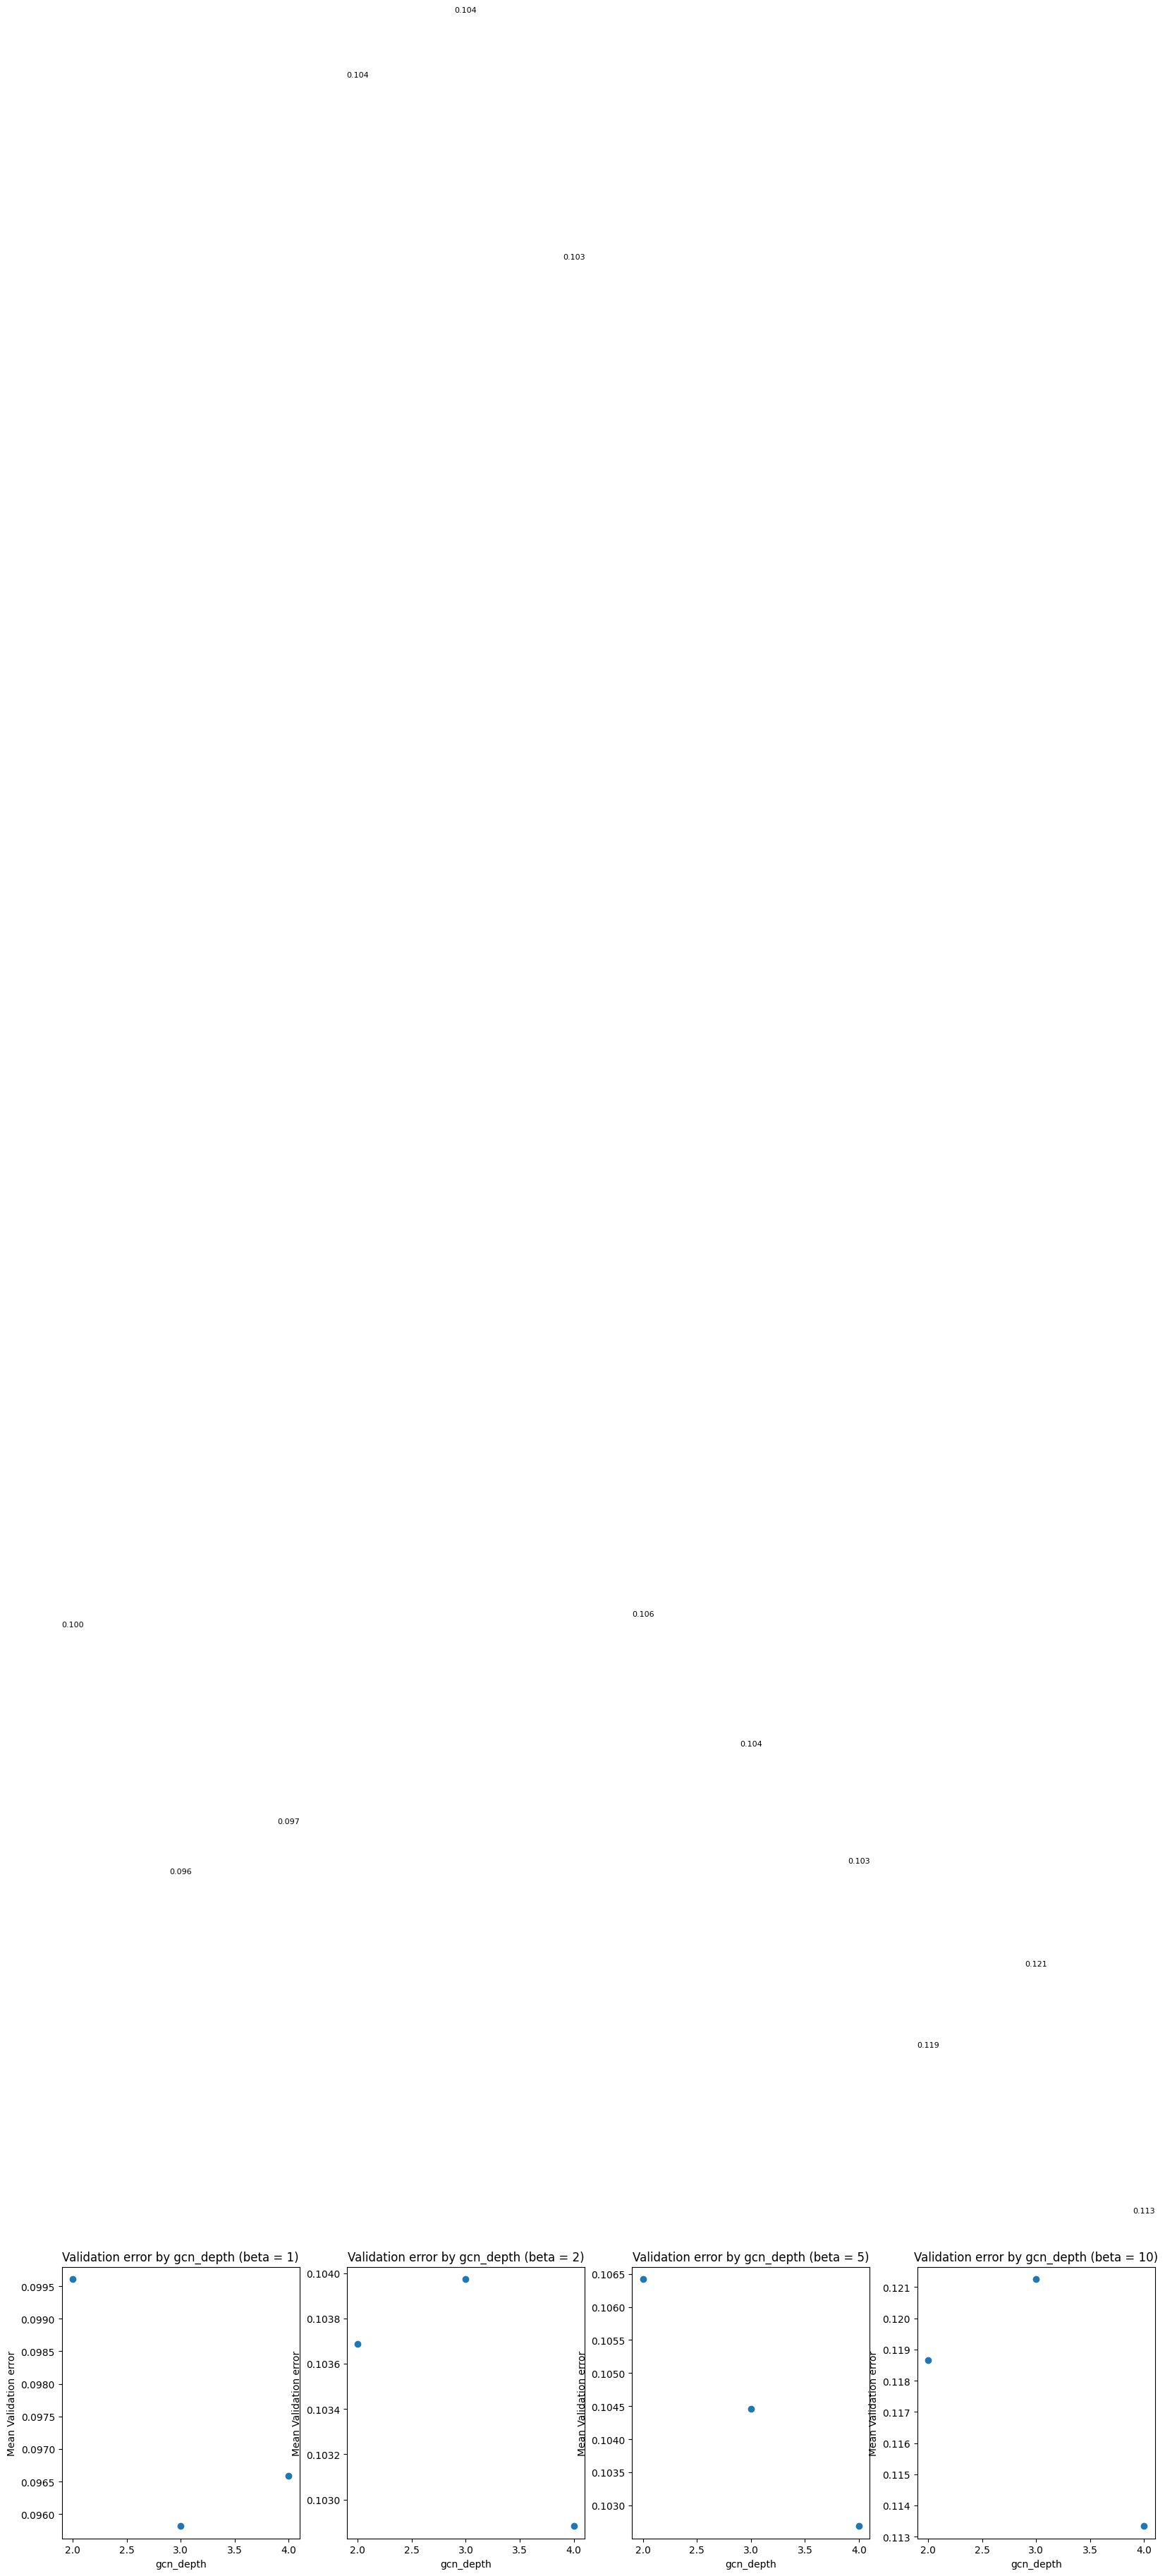

KeyboardInterrupt: 

In [24]:
import numpy as np

def plot_hyper_against_val_acc(df, hyper):
    # Get unique values for the hyperparameter
    unique_vals = df[hyper].unique()
    
    # Get unique beta values
    unique_betas = df['beta'].unique()
    
    # Create subplots for each beta
    fig, axes = plt.subplots(1, len(unique_betas), figsize=(5*len(unique_betas), 5))
    if len(unique_betas) == 1:
        axes = [axes]
    
    for beta_idx, beta_val in enumerate(unique_betas):
        ax = axes[beta_idx]
        
        # Filter data for this specific beta
        beta_subset = df[df['beta'] == beta_val]
        
        # Group by hyperparameter value and calculate mean val_acc
        hyper_acc = 1 - beta_subset.groupby(hyper)['val_acc'].mean()
        
        # Create bar plot
        if hyper == "lr":
            xvals = np.log10(hyper_acc.index)
        else:
            xvals = hyper_acc.index
        bars = ax.scatter(xvals, hyper_acc.values)
        
        # Add value labels on bars
        for j, v in enumerate(hyper_acc.values):
            ax.text(hyper_acc.index[j], v + 0.01, f'{v:.3f}', 
                   ha='center', va='bottom', fontsize=8)
        
        ax.set_title(f'Validation error by {hyper} (beta = {beta_val})')
        ax.set_xlabel(hyper)
        ax.set_ylabel('Mean Validation error')

        # ax.set_ylim(0, 1)
        # ax.semilogy()
    # plt.tight_layout()

    plt.show()

plt.close('all')
for hyper in ["lr", "batch_size", "gcn_depth", "gcn_min", "mlp_depth", "mlp_max"]:
    plot_hyper_against_val_acc(df, hyper)